In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


In [2]:
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [3]:
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [4]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [20]:
deu_eng = deu_eng[:5000,:]

In [6]:
deu_eng

array([['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ['Run!', 'Lauf!'],
       ...,
       ['Tom is a poet.', 'Tom ist ein Poet.'],
       ['Tom is a slob.', 'Tom ist ein Chaot.'],
       ['Tom is a wimp.', 'Tom ist ein Weichei.']], dtype='<U380')

In [7]:
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ['Run', 'Lauf'],
       ...,
       ['Tom is a poet', 'Tom ist ein Poet'],
       ['Tom is a slob', 'Tom ist ein Chaot'],
       ['Tom is a wimp', 'Tom ist ein Weichei']], dtype='<U380')

In [8]:
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ['run', 'lauf'],
       ...,
       ['tom is a poet', 'tom ist ein poet'],
       ['tom is a slob', 'tom ist ein chaot'],
       ['tom is a wimp', 'tom ist ein weichei']], dtype='<U380')

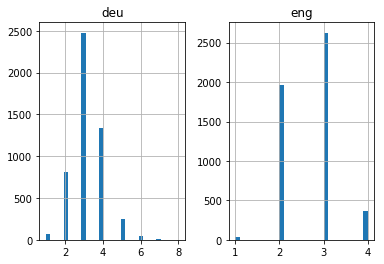

In [9]:
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [10]:
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [11]:
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 1391


In [12]:
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 2330


In [13]:
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [14]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [15]:
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [16]:
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [17]:
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [19]:
rms = optimizers.RMSprop(lr=0.001,rho=0.8)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [21]:
filename = 'model_file'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Train on 3200 samples, validate on 800 samples
Epoch 1/30
3200/3200 [==============================] - 22s 7ms/step - loss: 5.1442 - val_loss: 2.5793

Epoch 00001: val_loss improved from inf to 2.57926, saving model to model_file
Epoch 2/30
3200/3200 [==============================] - 18s 6ms/step - loss: 2.4294 - val_loss: 2.3223

Epoch 00002: val_loss improved from 2.57926 to 2.32234, saving model to model_file
Epoch 3/30
3200/3200 [==============================] - 18s 6ms/step - loss: 2.2625 - val_loss: 2.2164

Epoch 00003: val_loss improved from 2.32234 to 2.21644, saving model to model_file
Epoch 4/30
3200/3200 [==============================] - 18s 6ms/step - loss: 2.1477 - val_loss: 2.1510

Epoch 00004: val_loss improved from 2.21644 to 2.15095, saving model to model_file
Epoch 5/30
3200/3200 [==============================] - 22s 7ms/step - loss: 2.0127 - val_loss: 2.1941

Epoch 00005: val_loss did not improve from 2.15095
Epoch 6/30
3200/3200 [==============================] 

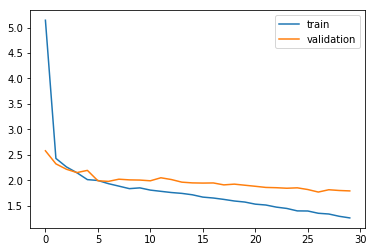

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [23]:
model = load_model('model_file')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [24]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [25]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [30]:
pred_df = pd.DataFrame({'actual' : test[:,0],'German':test[:,1] ,'predicted' : preds_text})

In [31]:
pred_df.sample(15)

,German,actual,predicted
343,ich lüge nicht,i dont lie,im not
864,frag einen fachmann,ask an expert,its is
649,ich bin in einer gang,im in a gang,im am
767,ich bin ruiniert,im ruined,im am
372,übernehmen sie die kontrolle,take control,its it
993,das ist alles,that is all,its is it
357,warten sie auf uns,wait for us,come is
661,tom will es,tom wants it,tom it
789,tom geht zu fuß,tom walks,tom
531,du fehlst uns,we miss you,come it
